In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True, precision=3)

import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2

In [6]:
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist # cdist принимает размерности (N_samples, N_features)

from scipy.cluster import hierarchy as hierarchy_lib
from hierarchical_algorithm import hierarchy

from sklearn.mixture import GaussianMixture
from em_algorithm import em

from sklearn.cluster import DBSCAN
from dbscan_algorithm import dbscan

# Wine Clustering

## Анализ датасета и визуализация

In [7]:
data = pd.read_csv("wine-clustering.csv")
data.head(5)

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [8]:
data_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=data)
data_emb_pca = PCA(n_components=2).fit_transform(data)

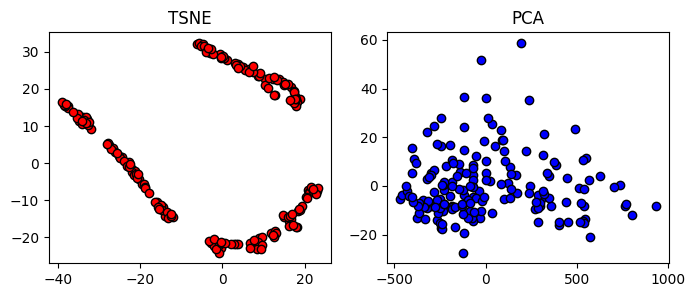

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(data_emb_tsne[:, 0], data_emb_tsne[:, 1], c='red', edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_emb_pca[:, 0], data_emb_pca[:, 1], c='blue', edgecolors='k')
axes[1].set_title("PCA")

# plt.show()
plt.savefig("../fall-24/students/ap-vyugina/lab1/assets/wine.png", dpi=120, bbox_inches='tight')

Предположение: алгоритмы должны выделить 4 кластера. PCA не справился с визуализацией, так как данные могут быть разделимы нелинейно.

In [13]:
scaled_data = StandardScaler().fit_transform(data.to_numpy())

## Иерархическая кластеризация и дендрограмма

(178, 178)


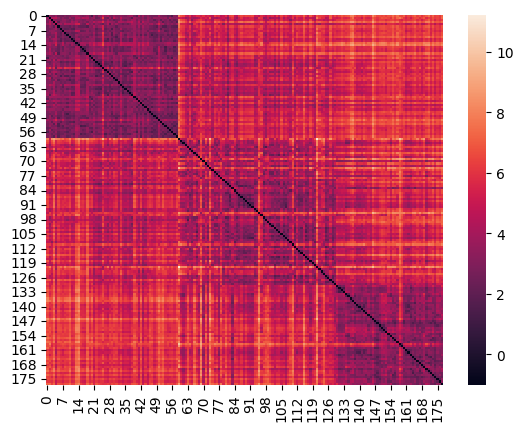

In [14]:
distances2plot = cdist(scaled_data, scaled_data)
np.fill_diagonal(distances2plot, -1)
sns.heatmap(distances2plot)
print(distances2plot.shape)

In [15]:
distances = cdist(scaled_data, scaled_data)
np.fill_diagonal(distances, np.inf)
distances.shape

(178, 178)

In [17]:
%%time
pairwise_distances, all_clusters_power = hierarchy(distances)

CPU times: total: 62.5 ms
Wall time: 59 ms


In [18]:
linkage_matrix = np.array([]).reshape((0, 4))
for k, v in pairwise_distances.items():
    row = np.array([k[0], k[1], v, all_clusters_power[k[0]] + all_clusters_power[k[1]]])
    linkage_matrix = np.vstack([linkage_matrix, row])

linkage_matrix.shape

(177, 4)

Text(0.5, 1.0, 'Scipy Implementation')

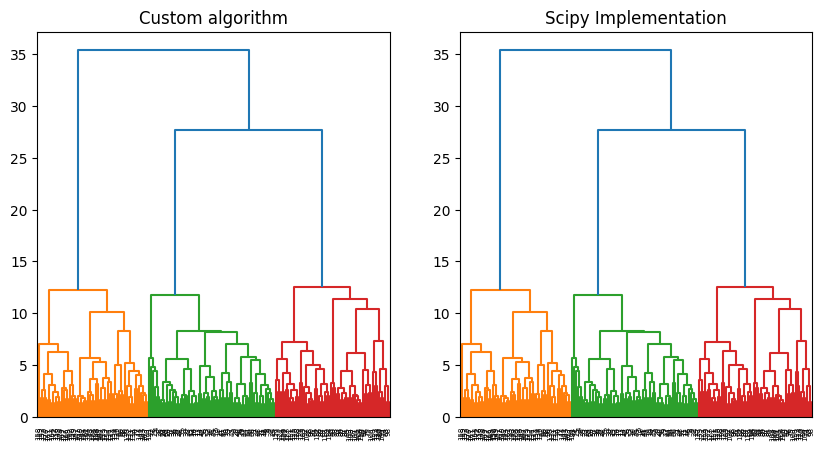

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dm0 = hierarchy_lib.dendrogram(linkage_matrix, ax=axes[0])
axes[0].set_title("Custom algorithm")

Z = hierarchy_lib.linkage(scaled_data, 'ward')
dm1 = hierarchy_lib.dendrogram(Z, ax=axes[1])
axes[1].set_title("Scipy Implementation")


Вывод: можно разбить на 2 кластера

## EM-алгоритм

In [21]:
import random
random.seed(0)

In [25]:
y = em(scaled_data, 13, 4)
y.shape

(178,)

Text(0.5, 1.0, 'data')

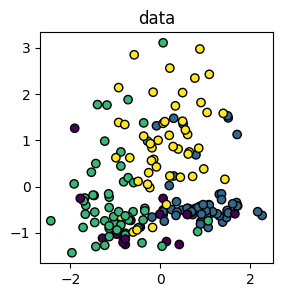

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
axes.scatter(scaled_data[:, 0], scaled_data[:, 1], c=y, edgecolors='k')
axes.set_title("data")

In [31]:
gm = GaussianMixture(n_components=4, 
                     max_iter=100, 
                     verbose=True, 
                     covariance_type='diag'
                    ).fit(scaled_data)
y = gm.predict(scaled_data)

Initialization 0
  Iteration 10
Initialization converged.


Text(0.5, 1.0, 'data')

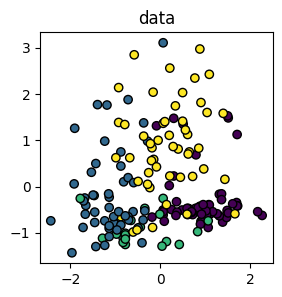

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
axes.scatter(scaled_data[:, 0], scaled_data[:, 1], c=y, edgecolors='k')
axes.set_title("data")

## DBScan

In [33]:
N = len(data)
epsilon = 2.5
min_samples = 10

In [34]:
%%time
roles, lbls = dbscan(scaled_data, epsilon, min_samples)

CPU times: total: 31.2 ms
Wall time: 18.1 ms


In [35]:
%%time
lbls_db = DBSCAN(eps=epsilon, min_samples=min_samples).fit_predict(scaled_data)

CPU times: total: 0 ns
Wall time: 6.05 ms


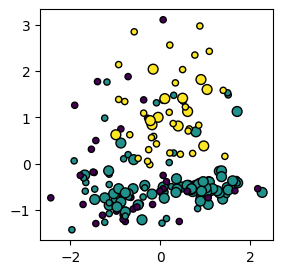

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

size = roles.copy()
size[size!=1] = 20
size[size==1] = 50

colors = lbls.copy()
axes.scatter(scaled_data[:, 0], scaled_data[:, 1], s=size, c=colors, edgecolors='k')
# axes.scatter(data[:, 0], data[:, 1], s=size, c=colors, edgecolors='k')


# Mall Customers

## Анализ датасета и визуализация

In [38]:
data = pd.read_csv("mall-customers.csv")
data["Gender"] = data["Gender"].replace(['Male', 'Female'], [0, 1])

data.head(5)

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_38504\4115090244.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Gender"] = data["Gender"].replace(['Male', 'Female'], [0, 1])


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [39]:
data_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(X=data)
data_emb_pca = PCA(n_components=2).fit_transform(data)

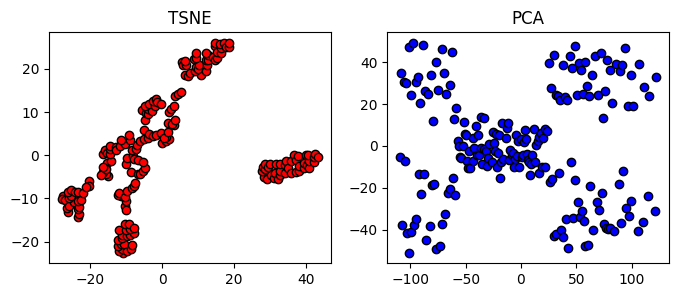

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(data_emb_tsne[:, 0], data_emb_tsne[:, 1], c='red', edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_emb_pca[:, 0], data_emb_pca[:, 1], c='blue', edgecolors='k')
axes[1].set_title("PCA")

# plt.show()
plt.savefig("../fall-24/students/ap-vyugina/lab1/assets/mall_customers.png", dpi=120, bbox_inches='tight')

Предположительно, алгоритмы должны выделить 5 кластеров.

In [41]:
scaled_data = StandardScaler().fit_transform(data)

## Дендрограмма и иерархический алгоритм

(200, 200)


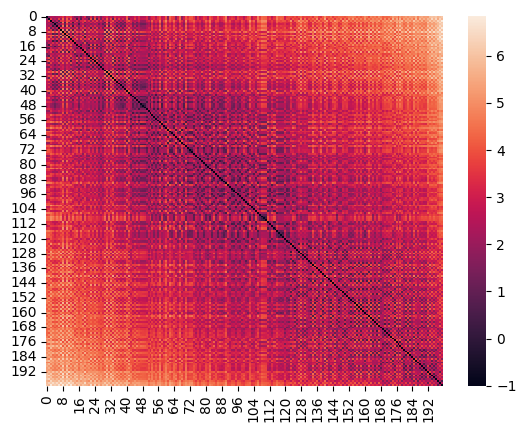

In [42]:
distances2plot = cdist(scaled_data, scaled_data)
np.fill_diagonal(distances2plot, -1)
sns.heatmap(distances2plot)
print(distances2plot.shape)

In [43]:
distances = cdist(scaled_data, scaled_data)
np.fill_diagonal(distances, np.inf)
distances.shape

(200, 200)

In [45]:
%%time
pairwise_distances, all_clusters_power = hierarchy(distances)

CPU times: total: 62.5 ms
Wall time: 48.2 ms


In [46]:
linkage_matrix = np.array([]).reshape((0, 4))
for k, v in pairwise_distances.items():
    row = np.array([k[0], k[1], v, all_clusters_power[k[0]] + all_clusters_power[k[1]]])
    linkage_matrix = np.vstack([linkage_matrix, row])

linkage_matrix.shape

(199, 4)

Text(0.5, 1.0, 'Scipy Implementation')

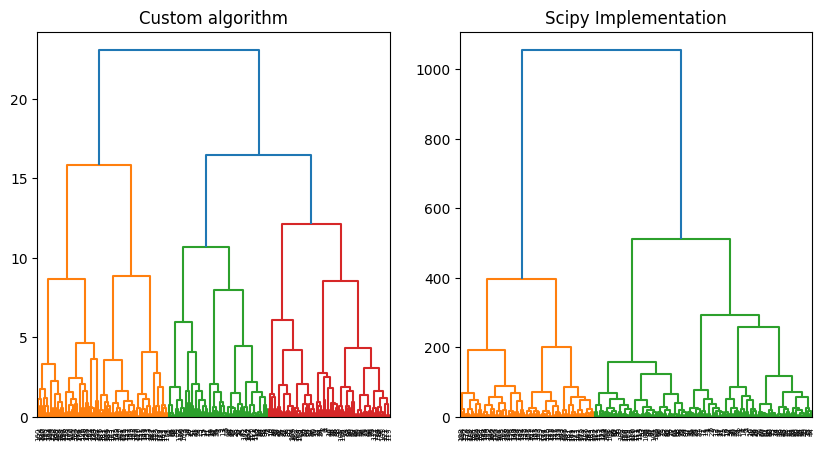

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dm0 = hierarchy_lib.dendrogram(linkage_matrix, ax=axes[0])
axes[0].set_title("Custom algorithm")

Z = hierarchy_lib.linkage(data, 'ward')
dm1 = hierarchy_lib.dendrogram(Z, ax=axes[1])
axes[1].set_title("Scipy Implementation")

# plt.show()
# plt.savefig("../fall-24/students/ap-vyugina/lab1/assets/hierarchical_wine.png", dpi=120, bbox_inches='tight')

Вывод: оптимальное число кластеров = 2

## EM-алгоритм

In [48]:
y = em(scaled_data, 5, 5)
y.shape

(200,)

Text(0.5, 1.0, 'data')

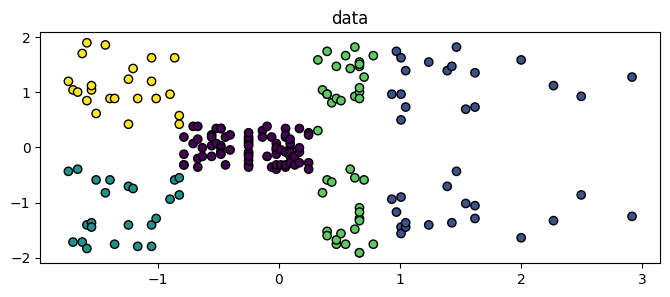

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(8, 3))
axes.scatter(scaled_data[:, 3], scaled_data[:, 4], c=y, edgecolors='k')
axes.set_title("data")


In [53]:
gm = GaussianMixture(n_components=4, 
                     max_iter=100, 
                     verbose=True, 
                     covariance_type='diag'
                    ).fit(scaled_data)
y = gm.predict(scaled_data)

Initialization 0
Initialization converged.


## DBScan

In [54]:
N = len(data)
epsilon = 1
min_samples = 10

In [55]:
%%time
roles, lbls = dbscan(scaled_data, epsilon, min_samples)

CPU times: total: 31.2 ms
Wall time: 38.9 ms


In [56]:
%%time
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(scaled_data)
lbls_db = db.labels_

CPU times: total: 0 ns
Wall time: 7.34 ms


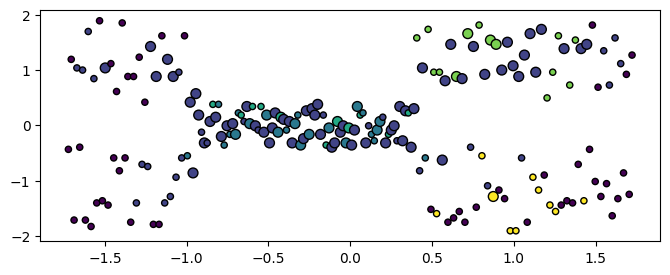

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(8, 3))

size = 20 * np.ones((N, ))
size[db.core_sample_indices_] = 50

colors = lbls_db.copy()
axes.scatter(scaled_data[:, 0], scaled_data[:, 4], s=size, c=colors, edgecolors='k')


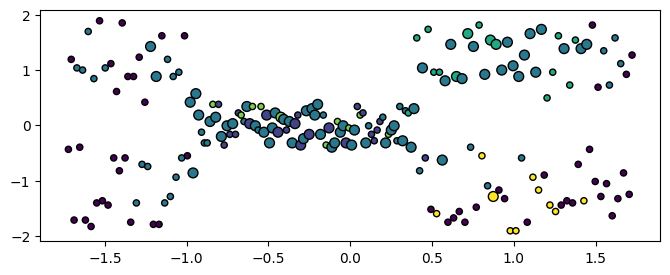

In [58]:
fig, axes = plt.subplots(1, 1, figsize=(8, 3))

size = roles.copy()
size[size!=1] = 20
size[size==1] = 50


colors = lbls.copy()
axes.scatter(scaled_data[:, 0], scaled_data[:, 4], s=size, c=colors, edgecolors='k')
